In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

Cloning into 'adahessian'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 562 (delta 90), reused 164 (delta 84), pack-reused 387
Receiving objects: 100% (562/562), 2.00 MiB | 1.52 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [5]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [6]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
#import torch_xla
#import torch_xla.core.xla_model as xm

from optimizer import set_parameter_requires_grad, initialize_model, train_and_test, test_model
from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
# classic dataset
train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=ToTensor())
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 12817016.21it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [8]:
# Use a small subset of the data
# only error: 'Subset' object has no attribute 'targets'
if False: # put False if don't want it
  rng = np.random.default_rng()

  indices = rng.choice(len(train_data), 1000, replace=False)
  train_data = torch.utils.data.Subset(train_data, indices)

  indices = rng.choice(len(test_data), 200, replace=False)
  test_data = torch.utils.data.Subset(test_data, indices)

In [9]:
print("train data of type:",type(train_data),"with length",len(train_data))
print("test data of type:",type(test_data),"with length",len(test_data))

train data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 50000
test data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 10000


In [10]:
print("samples of type",type(train_data[0]),"with length",len(train_data[0]))
print("   - First entry: Image of type",type(train_data[0][0]),"and size",train_data[0][0].size())
print("   - Second entry: Label of type",type(train_data[0][1]))
print("The first sample:\n",train_data[0])

samples of type <class 'tuple'> with length 2
   - First entry: Image of type <class 'torch.Tensor'> and size torch.Size([3, 32, 32])
   - Second entry: Label of type <class 'int'>
The first sample:
 (tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627

In [11]:
labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets, like 'Subset' objects
print(labels)

[0 1 2 3 4 5 6 7 8 9]


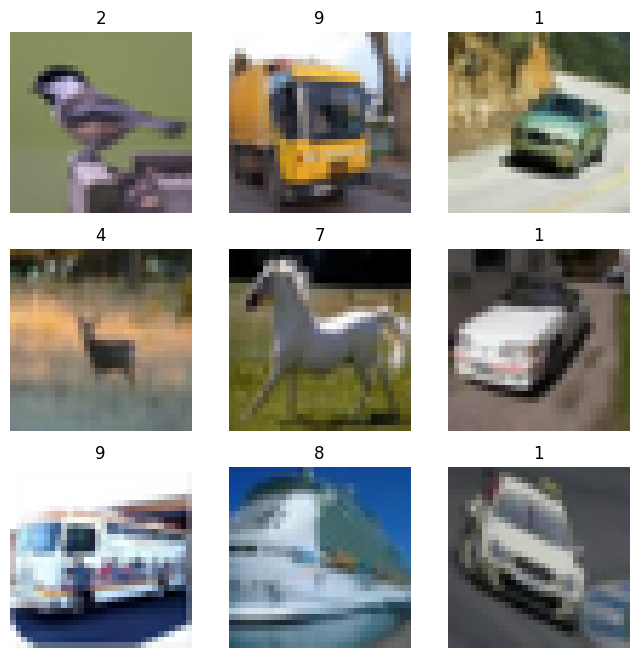

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

In [13]:
batch_size = 256
seed = 100
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #change batch size with our need
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#device = xm.xla_device()

Using cuda device


In [15]:
req_grad = True
# Initialize the model for this run
model, input_size = initialize_model(use_pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
# Send the model to GPU

model = model.to(device)
model.load_state_dict(torch.load('./drive/MyDrive/Opti-ML/model_weights/model_adahessian.pt', map_location=lambda storage, loc: storage.cuda(0)))
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if req_grad:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

[image_classification/optim_adahessian.py](https://github.com/amirgholami/adahessian/blob/master/image_classification/optim_adahessian.py) on github:


```
"""Implements Adahessian algorithm.
    It has been proposed in `ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 1). You can also try 0.5. For some tasks we found this to result in better performance.
        single_gpu (Bool, optional): Do you use distributed training or not "torch.nn.parallel.DistributedDataParallel" (default: True)
    """
```
- hessian_power is the "$k$"
- the weight decay is something like 0.1,...,0.0001


In [ ]:
lr=0.01 # default: 0.15
betas = (0.9, 0.999) # default: (0.9, 0.999)
weight_decay = 0.0005 # default: 0
hessian_power = 1 # default: 1
num_epoch = 100
momentum = 0.95

#optimizer_name = 'adahessian'
optimizer_name = 'SGD'

if optimizer_name == 'adahessian':
  optimizer = Adahessian(params_to_update, lr=lr, betas=betas, weight_decay=weight_decay,hessian_power=hessian_power) #set the parameter
elif optimizer_name == 'SGD':
  optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "adam":
  optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

scheduler_name = "multilr"
scheduler = None
if scheduler_name == "multilr":
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

path='./drive/MyDrive/Opti-ML/model_weights/model_0614_0.pt'
train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_loss_0614_0.txt'
train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_acc_0614_0.txt'
test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/test_loss_0614_0.txt'
test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/test_acc_0614_0.txt'

The following cell takes ~180 second/epoch for batchsize=16

In [ ]:
#check the warning, nothing more on the adahessian git
train_loss, list_testloss, lowest_loss, model_weights, train_acc, test_acc=train_and_test(model,trainloader,testloader,criterion,optimizer,scheduler,num_epoch,path,device)
with open(train_loss_path, 'w') as fp:
    for item in train_loss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(train_acc_path, 'w') as fp:
    for item in train_acc:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(test_loss_path, 'w') as fp:
    for item in list_testloss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(test_acc_path, 'w') as fp:
    for item in test_acc:
        # write each item on a new line
        fp.write("%s\n" % item)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------


/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 0.0018
Test Loss: 1.1665


  1%|          | 1/100 [00:38<1:04:04, 38.83s/it]

Train accuracy: 1.0000
Test accuracy: 0.7837
Epoch 1/99
----------
Train Loss: 0.0018
Test Loss: 1.1542


  2%|▏         | 2/100 [01:10<56:11, 34.40s/it]  

Train accuracy: 1.0000
Test accuracy: 0.7834
Epoch 2/99
----------
Train Loss: 0.0019
Test Loss: 1.1319


  3%|▎         | 3/100 [01:41<53:21, 33.00s/it]

Train accuracy: 1.0000
Test accuracy: 0.7842
Epoch 3/99
----------
Train Loss: 0.0019
Test Loss: 1.1162


  4%|▍         | 4/100 [02:12<51:39, 32.29s/it]

Train accuracy: 1.0000
Test accuracy: 0.7818
Epoch 4/99
----------
Train Loss: 0.0019
Test Loss: 1.0985


  5%|▌         | 5/100 [02:43<50:33, 31.93s/it]

Train accuracy: 1.0000
Test accuracy: 0.7840
Epoch 5/99
----------
Train Loss: 0.0019
Test Loss: 1.0803


  6%|▌         | 6/100 [03:15<49:49, 31.81s/it]

Train accuracy: 1.0000
Test accuracy: 0.7842
Epoch 6/99
----------
Train Loss: 0.0020
Test Loss: 1.0633


  7%|▋         | 7/100 [03:46<49:03, 31.65s/it]

Train accuracy: 1.0000
Test accuracy: 0.7826
Epoch 7/99
----------
Train Loss: 0.0021
Test Loss: 1.0591


  8%|▊         | 8/100 [04:18<48:25, 31.59s/it]

Train accuracy: 1.0000
Test accuracy: 0.7841
Epoch 8/99
----------
Train Loss: 0.0021
Test Loss: 1.0347


  9%|▉         | 9/100 [04:49<47:49, 31.53s/it]

Train accuracy: 1.0000
Test accuracy: 0.7841
Epoch 9/99
----------
Train Loss: 0.0022
Test Loss: 1.0293


 10%|█         | 10/100 [05:21<47:16, 31.52s/it]

Train accuracy: 1.0000
Test accuracy: 0.7848
Epoch 10/99
----------
Train Loss: 0.0022
Test Loss: 1.0172


 11%|█         | 11/100 [05:52<46:46, 31.54s/it]

Train accuracy: 1.0000
Test accuracy: 0.7844
Epoch 11/99
----------
Train Loss: 0.0023
Test Loss: 1.0060


 12%|█▏        | 12/100 [06:24<46:11, 31.50s/it]

Train accuracy: 1.0000
Test accuracy: 0.7832
Epoch 12/99
----------
Train Loss: 0.0023
Test Loss: 1.0042


 13%|█▎        | 13/100 [06:55<45:39, 31.49s/it]

Train accuracy: 1.0000
Test accuracy: 0.7843
Epoch 13/99
----------
Train Loss: 0.0024
Test Loss: 0.9897


 14%|█▍        | 14/100 [07:26<45:00, 31.40s/it]

Train accuracy: 1.0000
Test accuracy: 0.7850
Epoch 14/99
----------
Train Loss: 0.0025
Test Loss: 0.9870


 15%|█▌        | 15/100 [07:58<44:38, 31.52s/it]

Train accuracy: 1.0000
Test accuracy: 0.7839
Epoch 15/99
----------
Train Loss: 0.0025
Test Loss: 0.9690


 16%|█▌        | 16/100 [08:30<44:08, 31.54s/it]

Train accuracy: 1.0000
Test accuracy: 0.7854
Epoch 16/99
----------
Train Loss: 0.0026
Test Loss: 0.9694


 17%|█▋        | 17/100 [09:01<43:39, 31.57s/it]

Train accuracy: 1.0000
Test accuracy: 0.7860
Epoch 17/99
----------
Train Loss: 0.0026
Test Loss: 0.9549


 18%|█▊        | 18/100 [09:33<43:07, 31.55s/it]

Train accuracy: 1.0000
Test accuracy: 0.7841
Epoch 18/99
----------
Train Loss: 0.0026
Test Loss: 0.9555


 19%|█▉        | 19/100 [10:04<42:35, 31.56s/it]

Train accuracy: 1.0000
Test accuracy: 0.7848
Epoch 19/99
----------
Train Loss: 0.0026
Test Loss: 0.9437


 20%|██        | 20/100 [10:36<41:57, 31.47s/it]

Train accuracy: 1.0000
Test accuracy: 0.7846
Epoch 20/99
----------
Train Loss: 0.0027
Test Loss: 0.9408


 21%|██        | 21/100 [11:07<41:20, 31.40s/it]

Train accuracy: 1.0000
Test accuracy: 0.7858
Epoch 21/99
----------
Train Loss: 0.0027
Test Loss: 0.9329


 22%|██▏       | 22/100 [11:38<40:44, 31.34s/it]

Train accuracy: 1.0000
Test accuracy: 0.7845
Epoch 22/99
----------
Train Loss: 0.0028
Test Loss: 0.9302


 23%|██▎       | 23/100 [12:09<40:10, 31.30s/it]

Train accuracy: 1.0000
Test accuracy: 0.7843
Epoch 23/99
----------
Train Loss: 0.0028
Test Loss: 0.9239


 24%|██▍       | 24/100 [12:41<39:37, 31.28s/it]

Train accuracy: 1.0000
Test accuracy: 0.7859
Epoch 24/99
----------
Train Loss: 0.0029
Test Loss: 0.9171


 25%|██▌       | 25/100 [13:12<39:01, 31.22s/it]

Train accuracy: 1.0000
Test accuracy: 0.7850
Epoch 25/99
----------
Train Loss: 0.0029
Test Loss: 0.9151


 26%|██▌       | 26/100 [13:43<38:28, 31.19s/it]

Train accuracy: 1.0000
Test accuracy: 0.7854
Epoch 26/99
----------
Train Loss: 0.0030
Test Loss: 0.9151


 27%|██▋       | 27/100 [14:14<37:57, 31.20s/it]

Train accuracy: 1.0000
Test accuracy: 0.7850
Epoch 27/99
----------
Train Loss: 0.0031
Test Loss: 0.9063


 28%|██▊       | 28/100 [14:45<37:29, 31.24s/it]

Train accuracy: 1.0000
Test accuracy: 0.7852
Epoch 28/99
----------
Train Loss: 0.0030
Test Loss: 0.9055


 29%|██▉       | 29/100 [15:17<36:58, 31.24s/it]

Train accuracy: 1.0000
Test accuracy: 0.7840
Epoch 29/99
----------
Train Loss: 0.0030
Test Loss: 0.9052


 30%|███       | 30/100 [15:48<36:20, 31.15s/it]

Train accuracy: 1.0000
Test accuracy: 0.7853
Epoch 30/99
----------
Train Loss: 0.0030
Test Loss: 0.8970


 31%|███       | 31/100 [16:19<35:46, 31.11s/it]

Train accuracy: 1.0000
Test accuracy: 0.7864
Epoch 31/99
----------
Train Loss: 0.0032
Test Loss: 0.8917


 32%|███▏      | 32/100 [16:50<35:13, 31.08s/it]

Train accuracy: 1.0000
Test accuracy: 0.7868
Epoch 32/99
----------
Train Loss: 0.0032
Test Loss: 0.8888


 33%|███▎      | 33/100 [17:21<34:46, 31.15s/it]

Train accuracy: 1.0000
Test accuracy: 0.7863
Epoch 33/99
----------
Train Loss: 0.0031
Test Loss: 0.8908


 34%|███▍      | 34/100 [17:52<34:20, 31.22s/it]

Train accuracy: 1.0000
Test accuracy: 0.7877
Epoch 34/99
----------
Train Loss: 0.0033
Test Loss: 0.8875


 35%|███▌      | 35/100 [18:23<33:44, 31.14s/it]

Train accuracy: 1.0000
Test accuracy: 0.7877
Epoch 35/99
----------
Train Loss: 0.0032
Test Loss: 0.8892


 36%|███▌      | 36/100 [18:54<33:13, 31.15s/it]

Train accuracy: 1.0000
Test accuracy: 0.7868
Epoch 36/99
----------
Train Loss: 0.0032
Test Loss: 0.8808


 37%|███▋      | 37/100 [19:25<32:42, 31.14s/it]

Train accuracy: 1.0000
Test accuracy: 0.7868
Epoch 37/99
----------
Train Loss: 0.0031
Test Loss: 0.8881


 38%|███▊      | 38/100 [19:57<32:13, 31.19s/it]

Train accuracy: 1.0000
Test accuracy: 0.7872
Epoch 38/99
----------
Train Loss: 0.0031
Test Loss: 0.8791


 39%|███▉      | 39/100 [20:28<31:45, 31.24s/it]

Train accuracy: 1.0000
Test accuracy: 0.7872
Epoch 39/99
----------
Train Loss: 0.0032
Test Loss: 0.8814


 40%|████      | 40/100 [20:59<31:11, 31.19s/it]

Train accuracy: 1.0000
Test accuracy: 0.7869
Epoch 40/99
----------
Train Loss: 0.0032
Test Loss: 0.8800


 41%|████      | 41/100 [21:30<30:41, 31.21s/it]

Train accuracy: 1.0000
Test accuracy: 0.7888
Epoch 41/99
----------
Train Loss: 0.0033
Test Loss: 0.8773


 42%|████▏     | 42/100 [22:02<30:07, 31.16s/it]

Train accuracy: 1.0000
Test accuracy: 0.7873
Epoch 42/99
----------
Train Loss: 0.0032
Test Loss: 0.8759


 43%|████▎     | 43/100 [22:33<29:35, 31.15s/it]

Train accuracy: 1.0000
Test accuracy: 0.7880
Epoch 43/99
----------
Train Loss: 0.0032
Test Loss: 0.8717


 44%|████▍     | 44/100 [23:04<29:06, 31.18s/it]

Train accuracy: 1.0000
Test accuracy: 0.7869
Epoch 44/99
----------
Train Loss: 0.0031
Test Loss: 0.8705


 45%|████▌     | 45/100 [23:35<28:39, 31.26s/it]

Train accuracy: 1.0000
Test accuracy: 0.7889
Epoch 45/99
----------
Train Loss: 0.0031
Test Loss: 0.8752


 46%|████▌     | 46/100 [24:07<28:08, 31.27s/it]

Train accuracy: 1.0000
Test accuracy: 0.7879
Epoch 46/99
----------
Train Loss: 0.0032
Test Loss: 0.8694


 47%|████▋     | 47/100 [24:38<27:34, 31.22s/it]

Train accuracy: 1.0000
Test accuracy: 0.7884
Epoch 47/99
----------
Train Loss: 0.0032
Test Loss: 0.8697


 48%|████▊     | 48/100 [25:09<27:01, 31.17s/it]

Train accuracy: 1.0000
Test accuracy: 0.7885
Epoch 48/99
----------
Train Loss: 0.0033
Test Loss: 0.8650


 49%|████▉     | 49/100 [25:40<26:30, 31.18s/it]

Train accuracy: 1.0000
Test accuracy: 0.7886
Epoch 49/99
----------
Train Loss: 0.0032
Test Loss: 0.8704


 50%|█████     | 50/100 [26:11<25:57, 31.14s/it]

Train accuracy: 1.0000
Test accuracy: 0.7884
Epoch 50/99
----------
Train Loss: 0.0031
Test Loss: 0.8628


 51%|█████     | 51/100 [26:42<25:29, 31.20s/it]

Train accuracy: 1.0000
Test accuracy: 0.7883
Epoch 51/99
----------
Train Loss: 0.0030
Test Loss: 0.8702


 52%|█████▏    | 52/100 [27:14<24:58, 31.21s/it]

Train accuracy: 1.0000
Test accuracy: 0.7882
Epoch 52/99
----------
Train Loss: 0.0031
Test Loss: 0.8681


 53%|█████▎    | 53/100 [27:45<24:28, 31.24s/it]

Train accuracy: 1.0000
Test accuracy: 0.7882
Epoch 53/99
----------
Train Loss: 0.0031
Test Loss: 0.8695


 54%|█████▍    | 54/100 [28:16<23:57, 31.26s/it]

Train accuracy: 1.0000
Test accuracy: 0.7894
Epoch 54/99
----------
Train Loss: 0.0030
Test Loss: 0.8669


 55%|█████▌    | 55/100 [28:47<23:25, 31.22s/it]

Train accuracy: 1.0000
Test accuracy: 0.7887
Epoch 55/99
----------
Train Loss: 0.0031
Test Loss: 0.8702


 56%|█████▌    | 56/100 [29:19<22:54, 31.23s/it]

Train accuracy: 1.0000
Test accuracy: 0.7895
Epoch 56/99
----------
Train Loss: 0.0030
Test Loss: 0.8643


 57%|█████▋    | 57/100 [29:50<22:24, 31.26s/it]

Train accuracy: 1.0000
Test accuracy: 0.7895
Epoch 57/99
----------
Train Loss: 0.0031
Test Loss: 0.8664


 58%|█████▊    | 58/100 [30:21<21:49, 31.18s/it]

Train accuracy: 1.0000
Test accuracy: 0.7877
Epoch 58/99
----------
Train Loss: 0.0030
Test Loss: 0.8684


 59%|█████▉    | 59/100 [30:52<21:16, 31.14s/it]

Train accuracy: 1.0000
Test accuracy: 0.7880
Epoch 59/99
----------
Train Loss: 0.0031
Test Loss: 0.8673


 60%|██████    | 60/100 [31:23<20:47, 31.18s/it]

Train accuracy: 1.0000
Test accuracy: 0.7880
Epoch 60/99
----------
Train Loss: 0.0031
Test Loss: 0.8685


 61%|██████    | 61/100 [31:54<20:13, 31.11s/it]

Train accuracy: 1.0000
Test accuracy: 0.7889
Epoch 61/99
----------
Train Loss: 0.0030
Test Loss: 0.8712


 62%|██████▏   | 62/100 [32:26<19:45, 31.20s/it]

Train accuracy: 1.0000
Test accuracy: 0.7872
Epoch 62/99
----------
Train Loss: 0.0031
Test Loss: 0.8632


 63%|██████▎   | 63/100 [32:57<19:13, 31.18s/it]

Train accuracy: 1.0000
Test accuracy: 0.7896
Epoch 63/99
----------
Train Loss: 0.0031
Test Loss: 0.8642


 64%|██████▍   | 64/100 [33:28<18:44, 31.24s/it]

Train accuracy: 1.0000
Test accuracy: 0.7883
Epoch 64/99
----------
Train Loss: 0.0031
Test Loss: 0.8653


 65%|██████▌   | 65/100 [33:59<18:10, 31.16s/it]

Train accuracy: 1.0000
Test accuracy: 0.7882
Epoch 65/99
----------
Train Loss: 0.0031
Test Loss: 0.8649


 66%|██████▌   | 66/100 [34:30<17:37, 31.10s/it]

Train accuracy: 1.0000
Test accuracy: 0.7896
Epoch 66/99
----------
Train Loss: 0.0030
Test Loss: 0.8667


 67%|██████▋   | 67/100 [35:01<17:05, 31.06s/it]

Train accuracy: 1.0000
Test accuracy: 0.7880
Epoch 67/99
----------
Train Loss: 0.0031
Test Loss: 0.8630


 68%|██████▊   | 68/100 [35:32<16:33, 31.06s/it]

Train accuracy: 1.0000
Test accuracy: 0.7881
Epoch 68/99
----------
Train Loss: 0.0030
Test Loss: 0.8611


 69%|██████▉   | 69/100 [36:03<16:03, 31.08s/it]

Train accuracy: 1.0000
Test accuracy: 0.7890
Epoch 69/99
----------
Train Loss: 0.0031
Test Loss: 0.8661


 70%|███████   | 70/100 [36:34<15:30, 31.02s/it]

Train accuracy: 1.0000
Test accuracy: 0.7896
Epoch 70/99
----------
Train Loss: 0.0031
Test Loss: 0.8631


 71%|███████   | 71/100 [37:05<14:59, 31.01s/it]

Train accuracy: 1.0000
Test accuracy: 0.7893
Epoch 71/99
----------
Train Loss: 0.0031
Test Loss: 0.8652


 72%|███████▏  | 72/100 [37:36<14:28, 31.02s/it]

Train accuracy: 1.0000
Test accuracy: 0.7888
Epoch 72/99
----------
Train Loss: 0.0031
Test Loss: 0.8674


 73%|███████▎  | 73/100 [38:07<13:57, 31.01s/it]

Train accuracy: 1.0000
Test accuracy: 0.7893
Epoch 73/99
----------
Train Loss: 0.0030
Test Loss: 0.8633


 74%|███████▍  | 74/100 [38:38<13:26, 31.03s/it]

Train accuracy: 1.0000
Test accuracy: 0.7878
Epoch 74/99
----------
Train Loss: 0.0030
Test Loss: 0.8665


 75%|███████▌  | 75/100 [39:10<12:57, 31.12s/it]

Train accuracy: 1.0000
Test accuracy: 0.7885
Epoch 75/99
----------
Train Loss: 0.0030
Test Loss: 0.8650


 76%|███████▌  | 76/100 [39:41<12:27, 31.13s/it]

Train accuracy: 1.0000
Test accuracy: 0.7885
Epoch 76/99
----------
Train Loss: 0.0031
Test Loss: 0.8677


 77%|███████▋  | 77/100 [40:12<11:57, 31.18s/it]

Train accuracy: 1.0000
Test accuracy: 0.7905
Epoch 77/99
----------
Train Loss: 0.0031
Test Loss: 0.8599


 78%|███████▊  | 78/100 [40:43<11:27, 31.26s/it]

Train accuracy: 1.0000
Test accuracy: 0.7907
Epoch 78/99
----------
Train Loss: 0.0031
Test Loss: 0.8656


 79%|███████▉  | 79/100 [41:15<10:57, 31.33s/it]

Train accuracy: 1.0000
Test accuracy: 0.7885
Epoch 79/99
----------
Train Loss: 0.0030
Test Loss: 0.8630


 80%|████████  | 80/100 [41:46<10:26, 31.34s/it]

Train accuracy: 1.0000
Test accuracy: 0.7885
Epoch 80/99
----------
Train Loss: 0.0030
Test Loss: 0.8616


 81%|████████  | 81/100 [42:17<09:53, 31.25s/it]

Train accuracy: 1.0000
Test accuracy: 0.7904
Epoch 81/99
----------
Train Loss: 0.0030
Test Loss: 0.8639


 82%|████████▏ | 82/100 [42:48<09:19, 31.07s/it]

Train accuracy: 1.0000
Test accuracy: 0.7897
Epoch 82/99
----------
Train Loss: 0.0031
Test Loss: 0.8673


 83%|████████▎ | 83/100 [43:19<08:47, 31.03s/it]

Train accuracy: 1.0000
Test accuracy: 0.7888
Epoch 83/99
----------
Train Loss: 0.0030
Test Loss: 0.8625


 84%|████████▍ | 84/100 [43:50<08:17, 31.09s/it]

Train accuracy: 1.0000
Test accuracy: 0.7896
Epoch 84/99
----------
Train Loss: 0.0030
Test Loss: 0.8704


 85%|████████▌ | 85/100 [44:21<07:46, 31.13s/it]

Train accuracy: 1.0000
Test accuracy: 0.7896
Epoch 85/99
----------
Train Loss: 0.0030
Test Loss: 0.8648


 86%|████████▌ | 86/100 [44:52<07:15, 31.08s/it]

Train accuracy: 1.0000
Test accuracy: 0.7891
Epoch 86/99
----------
Train Loss: 0.0031
Test Loss: 0.8659


 87%|████████▋ | 87/100 [45:24<06:46, 31.29s/it]

Train accuracy: 1.0000
Test accuracy: 0.7890
Epoch 87/99
----------
Train Loss: 0.0030
Test Loss: 0.8639


 88%|████████▊ | 88/100 [45:55<06:14, 31.25s/it]

Train accuracy: 1.0000
Test accuracy: 0.7887
Epoch 88/99
----------
Train Loss: 0.0030
Test Loss: 0.8679


 89%|████████▉ | 89/100 [46:26<05:43, 31.21s/it]

Train accuracy: 1.0000
Test accuracy: 0.7890
Epoch 89/99
----------
Train Loss: 0.0031
Test Loss: 0.8667


 90%|█████████ | 90/100 [46:58<05:12, 31.30s/it]

Train accuracy: 1.0000
Test accuracy: 0.7893
Epoch 90/99
----------
Train Loss: 0.0030
Test Loss: 0.8656


 91%|█████████ | 91/100 [47:29<04:41, 31.25s/it]

Train accuracy: 1.0000
Test accuracy: 0.7887
Epoch 91/99
----------
Train Loss: 0.0030
Test Loss: 0.8657


 92%|█████████▏| 92/100 [48:01<04:10, 31.33s/it]

Train accuracy: 1.0000
Test accuracy: 0.7883
Epoch 92/99
----------
Train Loss: 0.0030
Test Loss: 0.8668


 93%|█████████▎| 93/100 [48:32<03:39, 31.37s/it]

Train accuracy: 1.0000
Test accuracy: 0.7885
Epoch 93/99
----------
Train Loss: 0.0030
Test Loss: 0.8654


 94%|█████████▍| 94/100 [49:04<03:09, 31.54s/it]

Train accuracy: 1.0000
Test accuracy: 0.7891
Epoch 94/99
----------
Train Loss: 0.0030
Test Loss: 0.8644


 95%|█████████▌| 95/100 [49:36<02:38, 31.64s/it]

Train accuracy: 1.0000
Test accuracy: 0.7894
Epoch 95/99
----------
Train Loss: 0.0031
Test Loss: 0.8643


 96%|█████████▌| 96/100 [50:07<02:06, 31.60s/it]

Train accuracy: 1.0000
Test accuracy: 0.7893
Epoch 96/99
----------
Train Loss: 0.0030
Test Loss: 0.8703


 97%|█████████▋| 97/100 [50:39<01:34, 31.58s/it]

Train accuracy: 1.0000
Test accuracy: 0.7877
Epoch 97/99
----------
Train Loss: 0.0030
Test Loss: 0.8638


 98%|█████████▊| 98/100 [51:11<01:03, 31.70s/it]

Train accuracy: 1.0000
Test accuracy: 0.7887
Epoch 98/99
----------
Train Loss: 0.0030
Test Loss: 0.8649


 99%|█████████▉| 99/100 [51:42<00:31, 31.64s/it]

Train accuracy: 1.0000
Test accuracy: 0.7890
Epoch 99/99
----------
Train Loss: 0.0030
Test Loss: 0.8679


100%|██████████| 100/100 [52:14<00:00, 31.34s/it]

Train accuracy: 1.0000
Test accuracy: 0.7903


In [ ]:
testloader = DataLoader(test_data, batch_size=1, shuffle=True)
accuracy = test_model(model,testloader,path,device)
print(f"accuracy={accuracy}")

accuracy=0.7907


lr=0.001 # default: 0.15
betas = (0.9, 0.999) # default: (0.9, 0.999)
weight_decay = 0.0001 # default: 0
hessian_power = 1 # default: 1
epoch = 50
=> accuracy 0.5308

if epoch=10 => accuracy 0.5248

if lr=0.01 => accuracy 0.7088

if lr= 0.1 => accuracy 0.7378

if lr=0.15 => 0.6935

if lr=0.1  weight_decay = 0.001 =>0.6934

if weight decay=0.0005 => 0.7316

if lr=0.1
betas = (0.9, 0.999)
weight_decay = 0.0001
hessian_power = 0.5 => 0.7573

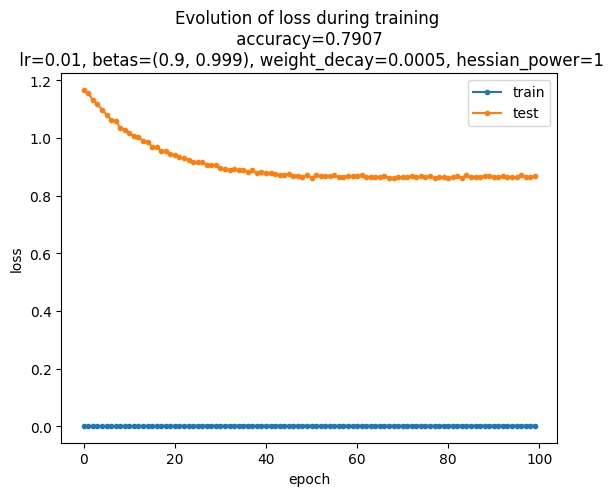

In [ ]:
plt.plot(train_loss,'.-')
plt.plot(list_testloss,'.-')
plt.title(f"Evolution of loss during training \n accuracy={accuracy} \n lr={lr}, betas={betas}, weight_decay={weight_decay}, hessian_power={hessian_power}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","test"])
plt.savefig("drive/MyDrive/Opti-ML/graphics/Adahessian_loss_0614_0.pdf")

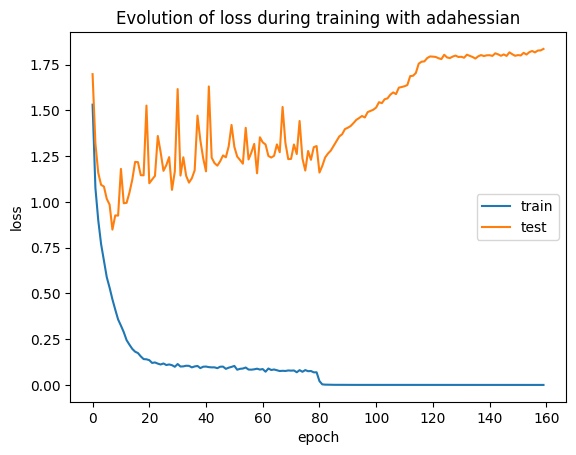

In [28]:
adah_train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_loss_0611_2.txt'
adah_test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_loss_0611_2.txt'
adah_train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_acc_0611_2.txt'
adah_test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_acc_0611_2.txt'
with open(adah_train_loss_path) as file:
  adah_train_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_test_loss_path) as file:
  adah_test_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_train_acc_path) as file:
  adah_train_acc = [np.float64(line.rstrip()) for line in file]
with open(adah_test_acc_path) as file:
  adah_test_acc = [np.float64(line.rstrip()) for line in file]

plt.plot(adah_train_loss)
plt.plot(adah_test_loss)
plt.title(f"Evolution of loss during training with adahessian")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","test"])
plt.show()